<a href="https://colab.research.google.com/github/kwonzero/Logo-Detection/blob/main/Similarity_Measure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [1]:
import os
import fnmatch
import zipfile
import time
from tqdm import tqdm


import cv2

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import pandas as pd
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = '/content/drive/MyDrive/Project/기업연계(Logo Detection)/Data'

#SEED


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(2024) # Seed 고정

# Upscaling Model

In [5]:
# Define model
sr2 = cv2.dnn_superres.DnnSuperResImpl_create()
sr2.readModel('/content/drive/MyDrive/Project/기업연계(Logo Detection)/Similarity Measure/EDSR_x3.pb')
sr2.setModel('edsr', 2)

# Functions


### Check background color

In [6]:
def check_background_black(gray_image): # Gray Scale 이미지만 받기
    gray = gray_image
    gray_cvt = cv2.bitwise_not(gray.copy()) # 비교를 위한 이미지 변환

    # 객체와 배경 분리를 위한 threshold 구하기
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    _, thresh_cvt = cv2.threshold(gray_cvt, 127, 255, cv2.THRESH_BINARY)

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    thresh_cvt = cv2.erode(thresh_cvt, None, iterations=2)
    thresh_cvt = cv2.dilate(thresh_cvt, None, iterations=2)

    # 컨투어 찾기
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # 면적은 EXTERNAL로 비교, 변환은 CCOMP
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    c0 = sorted_contours[0]
    c_area = cv2.contourArea(c0)

    contours_cvt, hierarchy_cvt = cv2.findContours(thresh_cvt.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours_cvt = sorted(contours_cvt, key=cv2.contourArea, reverse=True)
    c0_cvt = sorted_contours_cvt[0]
    c_area_cvt = cv2.contourArea(c0_cvt)

    # 면적에 따른 결과 반환
    check = True
    if c_area > c_area_cvt: # bitwise를 하지 않은 이미지의 객체 면적이 넓은 경우 -> 제대로 객체 검출이 안 된 것
        check = False
    return check

### Align Images

In [7]:
def align_images(image1, image2): # RGB 이미지 입력
    img1 = image1
    img2 = image2

    # upsampling image, 이미지가 작은 경우 keypoints를 구하기 어렵기에 이미지 해상도 증가
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]), interpolation = cv2.INTER_LANCZOS4)




    # image to gray scale, align 할 때 컬러가 방해요소가 되기에 gray 스케일 변환
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    # 이미지 변환을 위해 이미지들의 배경을 흰색으로 통일
    if check_background_black(img2):
        img2 = cv2.bitwise_not(img2)

    # AKAZE detector
    algorithm = cv2.AKAZE_create(descriptor_type = cv2.AKAZE_DESCRIPTOR_MLDB_UPRIGHT,
                                descriptor_size = 0,
                                descriptor_channels = 3,
                                threshold = 0.00002, # default 0.001 -> 적절히 감소시킬수록 변환이 잘 됨.(0.00002)
                                nOctaves = 4, # default 4 ->
                                nOctaveLayers = 10, # default 4 -> 늘려주니 성능 상승
                                diffusivity = cv2.KAZE_DIFF_PM_G1) # default PM_G2 -> PM_G1 괜찮음

    # compute the descriptors with ORB
    kp1, des1 = algorithm.detectAndCompute(img1,None)
    kp2, des2 = algorithm.detectAndCompute(img2,None)

    # Define Matcher
    # ORB의 경우 2진 문자열 기반의 방식 -> HAMMING 사용되어져야 함
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Aligning image
    kp1 = np.float32([kp1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
    kp2 = np.float32([kp2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)

    # 기준 이미지에 맞추어 호모그래피 생성
    M, _ = cv2.findHomography(kp2, kp1, cv2.RANSAC)

    # 호모그래피를 통한 이미지 변환
    aligned = cv2.warpPerspective(img2, M, (img1.shape[1], img1.shape[0]))

    return img1, img2, aligned

### Similarity

In [8]:
# 두 이미지의 코사인 유사도
def cosine_sim(x0, x1):
    dot_product = x0 @ x1
    magnitude1 = np.linalg.norm(x0)
    magnitude2 = np.linalg.norm(x1)
    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    return cosine_similarity

In [9]:
# 두 이미지의 유클리디안 유사도
def euclidean_dist(x0, x1):
    x = x0 - x1
    distance = np.sqrt(x @ x)
    return distance

### Get similarity DataFrame


In [10]:
def get_similarity(brands):
    cols = ['brand', 'name', 'image_type', 'euclidean', 'cosine']
    dicts = {col:[] for col in cols}
    for brand in brands:
        # 브랜드 폴더 별로 데이터 받아오기
        for i, file_name in tqdm(enumerate((os.listdir(f'{data}/image_for_similarity/{brand}')))):
            # 이미지 경로 설정
            path1 = f'{data}/LOGO/{brand}.png'
            path2 = f'{data}/image_for_similarity/{brand}/{file_name}'

            # 이미지 받아오기 및 RGB 변환
            img1 = cv2.imread(path1, 1)
            img2 = cv2.imread(path2, 1)
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

            # 이미지 조정
            img1, img2, aligned = align_images(img1, img2)

            # 이미지 Vector 생성
            img1_vec = img1.ravel() / 255.
            img2_vec = aligned.ravel() / 255.

            # Similarity 계산
            euclidean = euclidean_dist(img1_vec, img2_vec)
            cosine = cosine_sim(img1_vec, img2_vec)

            # Label 추출
            parts = file_name.split('_')
            if 'fake' in parts:
                label = 'fake'
            elif 'real' in parts:
                label = 'real'
            else:
                label = None

            # Dictionary에 데이터 저장
            lists = [brand, file_name, label, euclidean, cosine]
            for i, col in enumerate(cols):
                dicts[col].append(lists[i])
    # 저장된 데이터를 DataFrame형태로 반환
    matches_df = pd.DataFrame(dicts, columns=cols)
    return matches_df

### Get Metrics

In [11]:
# def get_Metrics(df):


# Similarity Measure

In [12]:
cols = ['brand', 'name', 'image_type', 'euclidean', 'cosine']
dicts = {col:[] for col in cols}

brands = ['adidas', 'puma', 'nike']
# brands = ['adidas']
start_time = time.time()

matches_df = get_similarity(brands)

end_time = time.time()
execution_time = end_time - start_time
print(f"실행 시간: {execution_time} 초")

39it [00:17,  2.19it/s]
23it [00:09,  2.39it/s]
50it [00:21,  2.34it/s]

실행 시간: 50.44462871551514 초


In [13]:
matches_df

,brand,name,image_type,euclidean,cosine
0,adidas,adidas_sports_real_1_1.jpg,real,124.131554,0.932055
1,adidas,fake_adidas_32.jpg,fake,265.742834,0.624711
2,adidas,fake_adidas_27.jpg,fake,225.266947,0.740365
3,adidas,fake_adidas_31.jpg,fake,171.660116,0.861111
4,adidas,fake_adidas_24.jpg,fake,191.194442,0.821601
...,...,...,...,...,...
107,nike,real_nike_02_1.jpg,real,103.402141,0.938524
108,nike,real_nike_27_1.jpg,real,119.087619,0.936351
109,nike,real_nike_03_1.jpg,real,140.251169,0.882971
110,nike,real_nike_01_1.jpg,real,123.470044,0.908603


<Figure size 1000x200 with 0 Axes>

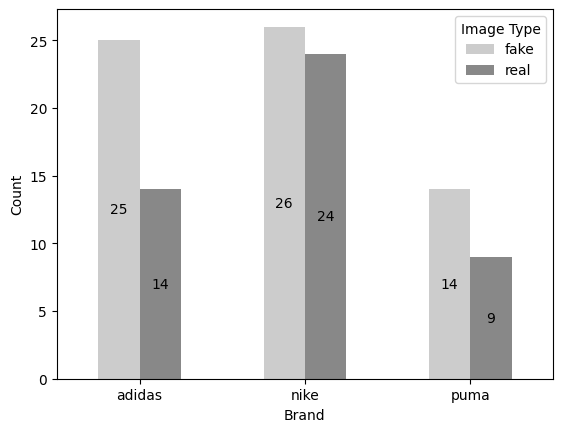

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called df
# If not, you can read it from your source

# Grouping data by brand and image_type and counting occurrences
grouped = matches_df.groupby(['brand', 'image_type']).size().unstack()
plt.figure(figsize=(10,2))
# Plotting
ax = grouped.plot(kind='bar', color=['#CCCCCC', '#888888', '#444444'])
plt.xlabel('Brand')
plt.ylabel('Count')
plt.legend(title='Image Type')

# Adding count labels inside the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2, y + height/2, int(height),
            horizontalalignment='center', verticalalignment='center')
plt.xticks(rotation=0)
plt.show()

In [15]:
matches_df[matches_df['brand'] =='puma'].name

39    real_puma_14_1.jpg
40      fake_puma_20.jpg
41    fake_puma_21_1.jpg
42    real_puma_10_1.jpg
43      fake_puma_09.jpg
44    real_puma_15_2.jpg
45    fake_puma_22_1.jpg
46    real_puma_14_2.jpg
47    real_puma_09_1.jpg
48    real_puma_12_1.jpg
49      fake_puma_18.jpg
50    real_puma_11_1.jpg
51    fake_puma_13_1.jpg
52      fake_puma_01.jpg
53    real_puma_03_1.jpg
54      fake_puma_05.png
55    real_puma_05_1.jpg
56      fake_puma_02.jpg
57    fake_puma_07_1.jpg
58    fake_puma_17_1.jpg
59      fake_puma_03.jpg
60    fake_puma_16_1.jpg
61      fake_puma_06.jpg
Name: name, dtype: object

In [16]:
fake = matches_df[matches_df.image_type =='fake']
real = matches_df[matches_df.image_type == 'real']
real_cosine_min = real.cosine.min() # 가장 덜 유사한 것
real_euclidean_max = real.euclidean.max() # 가장 거리가 먼 것

In [17]:
print(len(real), len(fake))

47 65


<ipython-input-18-407ccde58b60>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fake.cosine, label='fake')
<ipython-input-18-407ccde58b60>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(real.cosine, label='real')


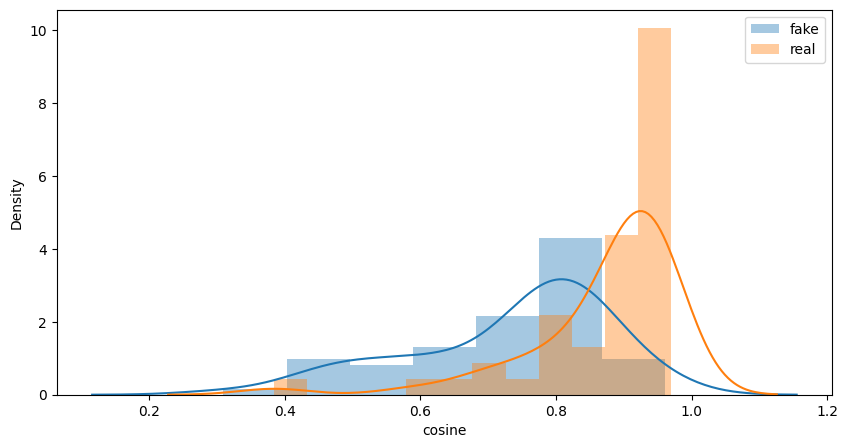

In [18]:
plt.figure(figsize=(10,5))
sns.distplot(fake.cosine, label='fake')
sns.distplot(real.cosine, label='real')
plt.legend()
plt.show()

<ipython-input-19-a7f46544ac64>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fake.euclidean, label='fake')
<ipython-input-19-a7f46544ac64>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(real.euclidean, label='real')


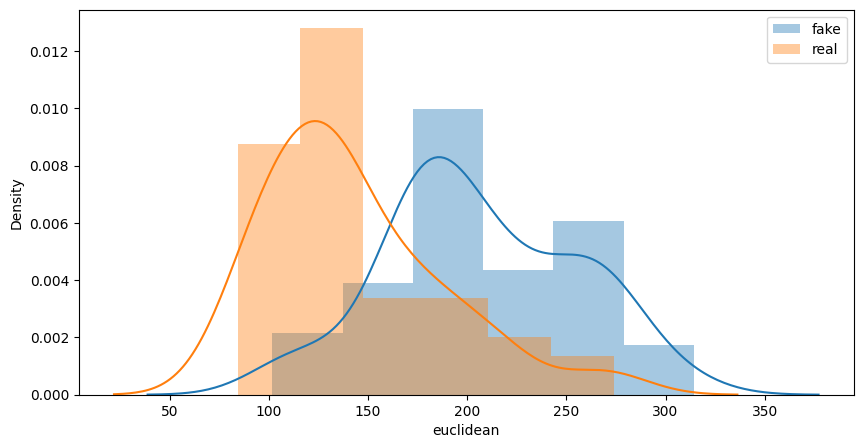

In [19]:
plt.figure(figsize=(10,5))
sns.distplot(fake.euclidean, label='fake')
sns.distplot(real.euclidean, label='real')
plt.legend()
plt.show()

In [20]:
matches_df.loc[:, 'pred_by_cosine'] = matches_df.cosine.apply(lambda x: 'fake' if x < 0.89 else 'real') # threshold : 0.89 -> F1-score : 0.782
matches_df.loc[:, 'pred_by_euclidean'] = matches_df.euclidean.apply(lambda x: 'fake' if x > 146 else 'real') # threshold : 146 -> F1-score : 0.802

In [21]:
f1_cosine = metrics.f1_score(matches_df.image_type, matches_df.pred_by_cosine, pos_label='real')
f1_euclidean = metrics.f1_score(matches_df.image_type, matches_df.pred_by_euclidean, pos_label='real')
print(f'cosine_f1 : {round(f1_cosine,3)}')
print(f'euclidean_f1 : {round(f1_euclidean,3)}')

cosine_f1 : 0.732
euclidean_f1 : 0.732


## Specificity

Specificity : 0.9230769230769231


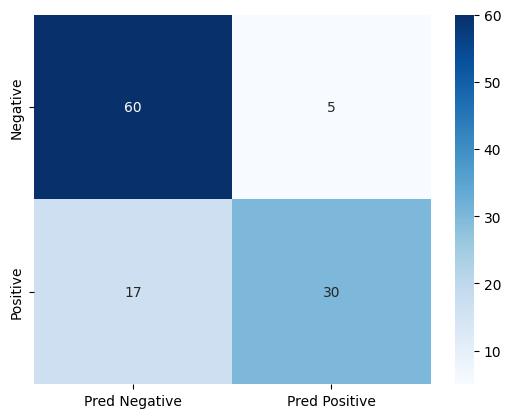

In [22]:
cosine_matrix = metrics.confusion_matrix(matches_df.image_type, matches_df.pred_by_cosine)
sns.heatmap(cosine_matrix, annot=True, cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['Negative', 'Positive'])

tn, fp, fn, tp = cosine_matrix.ravel()
print(f'Specificity : {tn / (tn+fp)}')

In [23]:
len(matches_df[matches_df.pred_by_cosine == matches_df.image_type])

90

Specificity : 0.9230769230769231


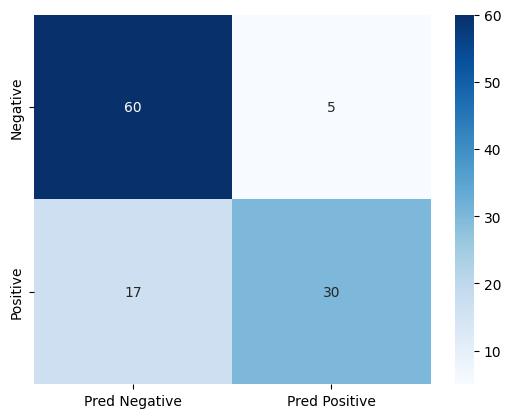

In [24]:
euclidean_matrix = metrics.confusion_matrix(matches_df.image_type, matches_df.pred_by_euclidean)
sns.heatmap(euclidean_matrix, annot=True, cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['Negative', 'Positive'])

tn, fp, fn, tp = euclidean_matrix.ravel()
print(f'Specificity : {tn / (tn+fp)}')

In [25]:
len(matches_df[matches_df.pred_by_euclidean == matches_df.image_type])

90

## Recall
가품이 진품으로 분류되는 것을 더 조심해야 한다면, 리콜(Recall)을 쓰는게 맞음

리콜은 실제 가품인 샘플들 중에서 모델이 가품으로 올바르게 분류한 비율을 나타냅니다.

즉, 모델이 실제 가품을 놓치지 않고 얼마나 잘 탐지하는지를 측정합니다.

따라서 리콜을 최적화하여 모델을 평가하고 비교하는 것이 중요함.

 높은 리콜 값은 실제 가품을 놓치는 것을 줄여줄 수 있으며, 따라서 이러한 상황에서 모델의 성능을 더 향상시킬 수 있습니다.

Recall : 0.6382978723404256


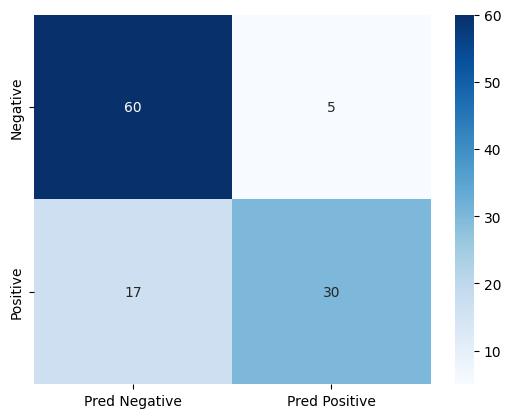

In [26]:
cosine_matrix = metrics.confusion_matrix(matches_df.image_type, matches_df.pred_by_cosine)
sns.heatmap(cosine_matrix, annot=True, cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['Negative', 'Positive'])

tn, fp, fn, tp = cosine_matrix.ravel()
print(f'Recall : {tp / (tp+fn)}')

Recall : 0.6382978723404256


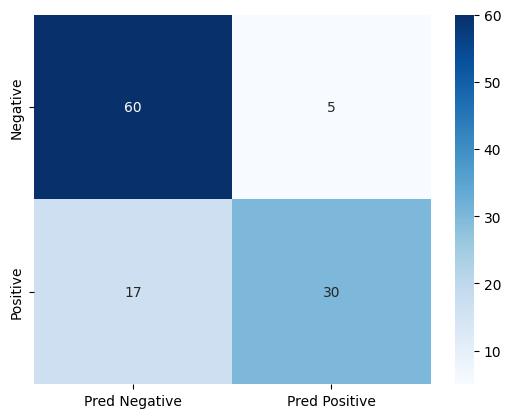

In [27]:
euclidean_matrix = metrics.confusion_matrix(matches_df.image_type, matches_df.pred_by_euclidean)
sns.heatmap(euclidean_matrix, annot=True, cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['Negative', 'Positive'])

tn, fp, fn, tp = euclidean_matrix.ravel()
print(f'Recall : {tp / (tp+fn)}')

## Precision
​진품과 가품을 분류하는 문제에서는 정밀도(Precision)를 쓰는 게 맞다고 생각함.

정밀도는 모델이 가품으로 분류한 샘플 중에서 실제로 가품인 비율을 나타내므로, 이 지표를 통해 모델이 얼마나 신뢰할 수 있는지를 알 수 있습니다.

가품을 정확하게 탐지하는 것이 중요한 경우에는 정밀도를 주로 고려하는 것이 좋습니다. 왜냐하면 가품으로 잘못 분류되는 경우가 적어야 하기 때문입니다.

따라서 정밀도를 최적화하여 모델을 평가하고 비교하는 것이 유용할 것입니다.


Precision : 0.8571428571428571


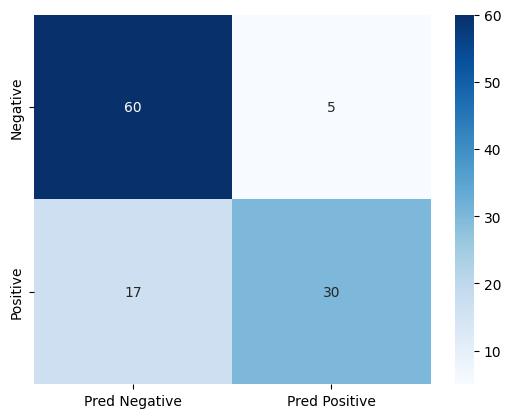

In [28]:
cosine_matrix = metrics.confusion_matrix(matches_df.image_type, matches_df.pred_by_cosine)
sns.heatmap(cosine_matrix, annot=True, cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['Negative', 'Positive'])

tn, fp, fn, tp = cosine_matrix.ravel()
print(f'Precision : { tp/(tp+fp)}')

Precision : 0.8571428571428571


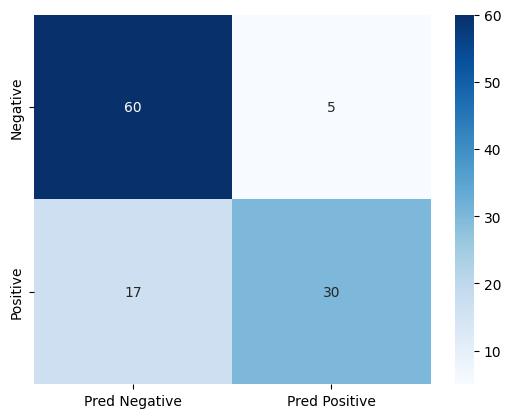

In [29]:
euclidean_matrix = metrics.confusion_matrix(matches_df.image_type, matches_df.pred_by_euclidean)
sns.heatmap(euclidean_matrix, annot=True, cmap='Blues', xticklabels=['Pred Negative', 'Pred Positive'], yticklabels=['Negative', 'Positive'])

tn, fp, fn, tp = euclidean_matrix.ravel()
print(f'Precision : { tp/(tp+fp)}')